# House Price Analysis with Linear Regression - Models and Predictions

---
___
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action= 'ignore', category= UserWarning)

#code to display all the columns without truncation
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/df_features_clean')

## Modeling and Prediction

### Feature Selection

Check correlation among features again. Making sure not to pick features with a strong correlation to each other to avoid multicollinearity.


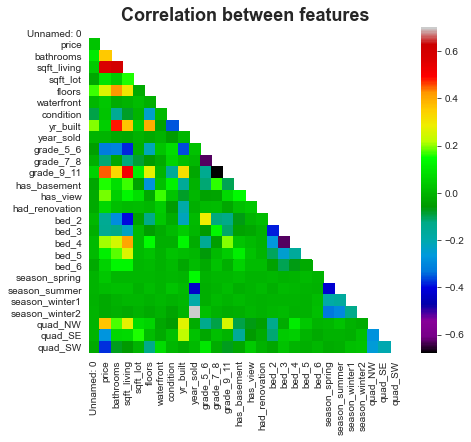

In [3]:
corr = df.corr()

plt.figure(figsize=(7,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(df.corr(), cmap= 'nipy_spectral', mask= mask)
plt.title("Correlation between features",weight='bold',fontsize=18)
plt.show()

Let's see which features have the highest correlations.

In [4]:
df_corr_stack = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df_corr_stack['pairs'] = list(zip(df_corr_stack.level_0, df_corr_stack.level_1))

df_corr_stack.set_index(['pairs'], inplace= True)

df_corr_stack.drop(columns= ['level_1', 'level_0'], inplace= True)
df_corr_stack.columns = ['cc']

df_corr_stack.drop_duplicates(inplace= True)

df_corr_stack[(df_corr_stack.cc > .55) & (df_corr_stack.cc < 1)]

,cc
pairs,
"(season_winter2, year_sold)",0.702430
"(grade_9_11, grade_7_8)",0.678661
"(bed_4, bed_3)",0.629682
"(grade_7_8, grade_5_6)",0.626479
"(bathrooms, sqft_living)",0.604185
"(sqft_living, price)",0.574037


In [5]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [6]:
y = df['price']
X = df.drop('price', axis= 1)

result = stepwise_selection(X, y)
print ('resulting features:')
print (result)

<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  quad_SE                        with p-value 0.0
Add  floors                         with p-value 0.0
Add  quad_NW                        with p-value 0.0
Add  has_basement                   with p-value 0.0


<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  grade_9_11                     with p-value 0.0
Add  quad_SW                        with p-value 0.0


<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_living                    with p-value 0.0
Add  yr_built                       with p-value 1.07628e-174


<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  grade_7_8                      with p-value 1.69101e-175
Add  has_view                       with p-value 9.99538e-119


<ipython-input-5-379af1f7e318>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


ValueError: list.remove(x): x not in list

The stepwise selection function suggested the following features:


|           |            |           |                |
|-----------|------------|-----------|----------------|
|grade_5_6  | yr_built   | quad_SW   | condition      |
|grade_7_8  | year_sold  | quad_SE   |  floors        |
|grade_9_11 |  bed_2     | quad_NW   |  bathrooms     |
|sqft_living|  bed_5     |waterfront | had_renovation |
|sqft_lot   |  bed_6     |  has_view | season_winter2 | 

### Model 1

In [ ]:
model1_df = df[['price', 'has_view', 'condition', 'waterfront', 'floors', 
                'year_sold', 'grade_5_6', 'grade_9_11', 
                'quad_SE', 'quad_SW', 'yr_built', 'sqft_living', 
                'bathrooms', 'bed_5', 'bed_2', 'had_renovation', 'has_view', 
                'sqft_lot', 'season_winter2']]

In [ ]:
outcome = 'price'
x_cols = model1_df.drop(columns= ['price'], axis= 1)

predictors = '+'.join(x_cols)
f = outcome + '~' + predictors
model = ols(formula = f, data= model1_df).fit()

model.summary()

#### Model 1: Q-Q Plot

In [ ]:
# Q-Q plot
residuals = model.resid
fig1 = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig1.show()

#### RMSE 

#### Train, Test Split

In [ ]:
# outcome = 'price'
# x_cols = model1_df.drop(columns= ['price', 'condition'], axis= 1)

# predictors = '+'.join(x_cols)
# f = outcome + '~' + predictors
# model = ols(formula = f, data= model1_df).fit()

# model.summary()

### Model 2: Log Transform Model 1 

In [ ]:
model2_df = model1_df.copy()

In [ ]:
model2_df.columns

In [ ]:
# list of continuous features to log transform them
cont = ['yr_built', 'sqft_living', 'sqft_lot']

In [ ]:
df_cont = model2_df[cont]

log_names = [f'{column}_log' for column in df_cont.columns]

model2_log = np.log(df_cont)
model2_log.columns = log_names

def normalize(feature):
    return (feature - feature.mean() / feature.std())

model2_log_norm = model2_log.apply(normalize)

In [ ]:
model2_log = pd.concat([model2_log_norm, model2_df], axis= 1)
model2_log.head()

In [ ]:
model2_log.drop(columns= ['yr_built', 'sqft_living', 'sqft_lot'], 
                inplace= True)

In [ ]:
X = model2_log.drop('price', axis= 1)
y = model2_log['price']

X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

In [ ]:
# Q-Q plot
residuals = model.resid
fig2 = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig2.show()

#### Train, test split

In [ ]:
# X = model2_log.drop('price', axis= 1)
# y = model2_log['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, 
                                                random_state = 42)

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

print ('Train RMSE: ', train_mse)
print ('Test RMSE: ', test_rmse)